In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

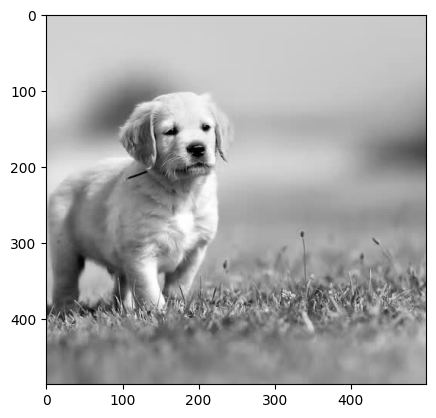

In [2]:
image = cv2.imread('Test Images/puppy.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

In [3]:
# create an initial array of harris, lambda_negative, and lambda_positive with the same dimension as the image, but only one channel
# and create an initial array of the eigen vectors for each pixel in the image
lambda_negative = np.zeros(image.shape[:2], dtype=np.float32)
eigen_vectors_negative = np.zeros((image.shape[0], image.shape[1], 2), dtype=np.float32)
lambda_positive = np.zeros(image.shape[:2], dtype=np.float32)
eigen_vectors_positive = np.zeros((image.shape[0], image.shape[1], 2), dtype=np.float32)
harris = np.zeros(image.shape[:2], dtype=np.float32)

In [4]:
# calculate the gradient of the image in both directions
I_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
I_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

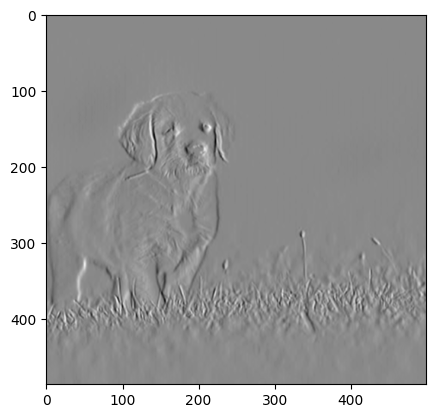

In [5]:
plt.imshow(I_x, cmap='gray')

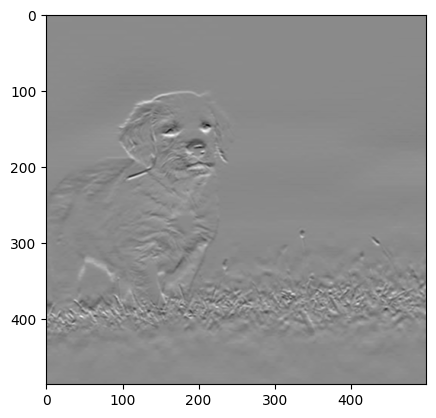

In [6]:
plt.imshow(I_y, cmap='gray')

In [7]:
from scipy.ndimage import gaussian_filter

# calculate the harris number, eigen values, and eigen vectors for each pixel in the image
I_xx = gaussian_filter(I_x ** 2, sigma=1)
I_yy = gaussian_filter(I_y ** 2, sigma=1)
I_xy = gaussian_filter(I_x * I_y, sigma=1)
for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
        S_xx = I_xx[i, j]
        S_yy = I_yy[i, j]
        S_xy = I_xy[i, j]
        
        # Harris
        det = S_xx * S_yy - S_xy ** 2
        trace = S_xx + S_yy
        k = 0.04
        harris[i, j] = det - k * trace ** 2
        
        # Eigen values and vectors
        # 0.5 * (trace +/- sqrt(4Ixy^2 - (Ix - Iy)^2))
        # lambda_positive[i, j] = 0.5 * (trace + np.sqrt(4 * I_xy ** 2 - (I_xx - I_yy) ** 2))
        # lambda_negative[i, j] = 0.5 * (trace - np.sqrt(4 * I_xy ** 2 - (I_xx - I_yy) ** 2))
        
        # Solve for eigen vectors knowing the eigen values
        # H * v = lambda * v
        # H = [I_xx I_xy; I_xy I_yy]
        
        eigen_values, eigen_vectors = np.linalg.eig(np.array([[S_xx, S_xy], [S_xy, S_yy]]))
        # Sort the eigen values and vectors
        idx = eigen_values.argsort()[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        
        lambda_negative[i, j] = eigen_values[1]
        lambda_positive[i, j] = eigen_values[0]
        eigen_vectors_negative[i, j] = eigen_vectors[:, 1]
        eigen_vectors_positive[i, j] = eigen_vectors[:, 0]

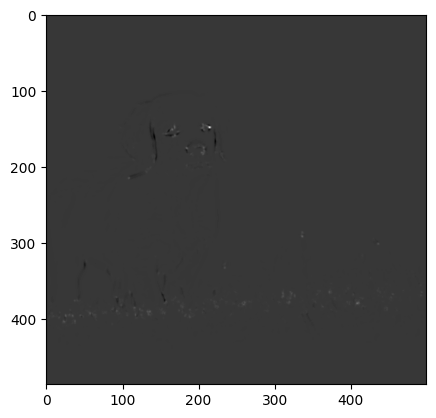

In [8]:
plt.imshow(harris, cmap='gray')

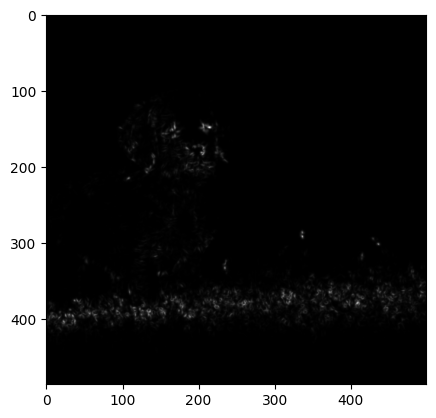

In [9]:
plt.imshow(lambda_negative, cmap='gray')

(0.0, 1000.0)

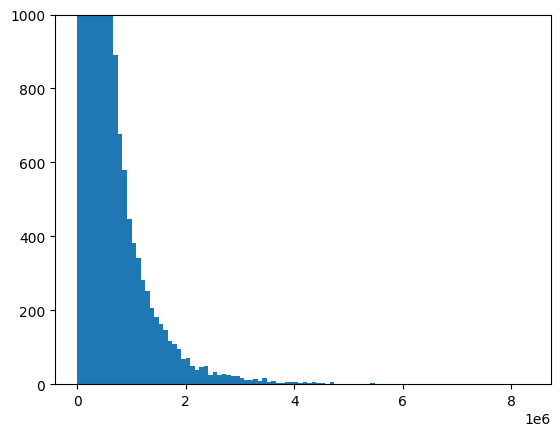

In [10]:
# plot a histogram of lambda_negative, with y limits to 0 to 1000
plt.hist(lambda_negative.flatten(), bins=100)
plt.ylim(0, 1000)

(0.0, 1000.0)

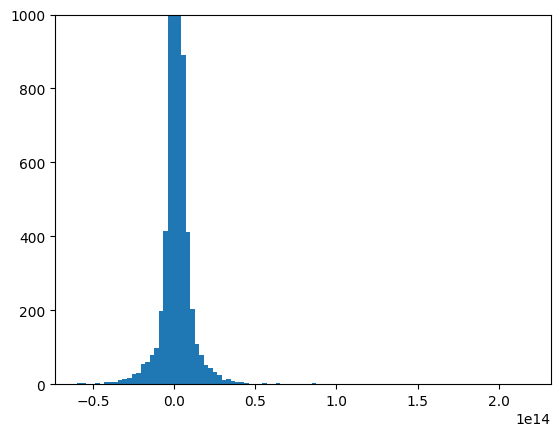

In [11]:
# plot a histogram of harris number
plt.hist(harris.flatten(), bins=100)
plt.ylim(0, 1000)

In [12]:
lambda_negative_threshold = 3 * 1e6
harris_threshold = 0.125 * 1e14

# create a mask of the pixels that are above the threshold
lambda_negative_mask = lambda_negative > lambda_negative_threshold
harris_mask = harris > harris_threshold

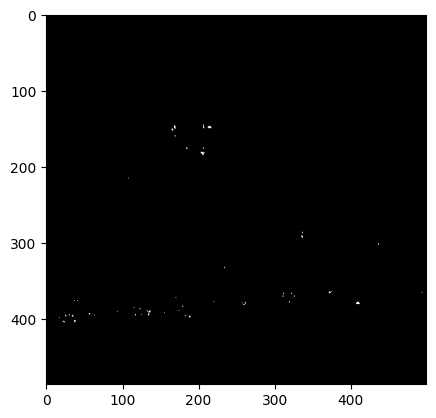

In [13]:
# plot the mask of the pixels that are above the threshold
plt.imshow(lambda_negative_mask, cmap='gray')

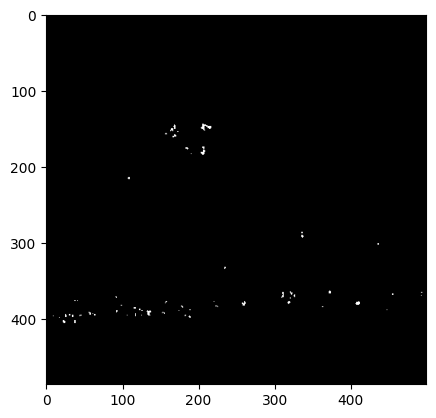

In [14]:
plt.imshow(harris_mask, cmap='gray')

In [15]:
# Apply non-max suppression within the mask
def non_max_suppression(image, mask):
    # create a copy of the image
    output = np.zeros(image.shape, dtype=np.float32)
    # get the coordinates of the pixels that are above the threshold
    coords = np.argwhere(mask)
    for coord in coords:
        x, y = coord
        # get the 3x3 window around the pixel
        window = image[x-1:x+2, y-1:y+2]
        # check if the pixel is the maximum in the window
        if image[x, y] >= np.max(window):
            output[x, y] = image[x, y]
    return output

In [16]:
harris_corners = non_max_suppression(harris, harris_mask)

In [17]:
lambda_corners = non_max_suppression(lambda_negative, lambda_negative_mask)

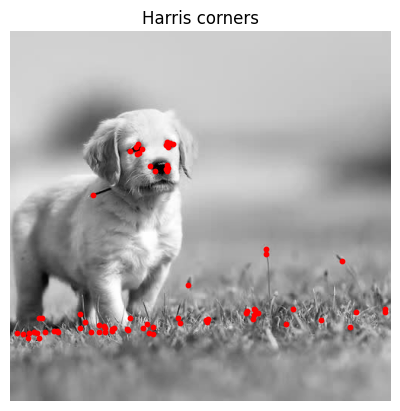

In [18]:
coords = np.argwhere(harris_corners)
plt.imshow(image, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], c='r', s=10)
plt.title('Harris corners')
plt.axis('off')
plt.show()

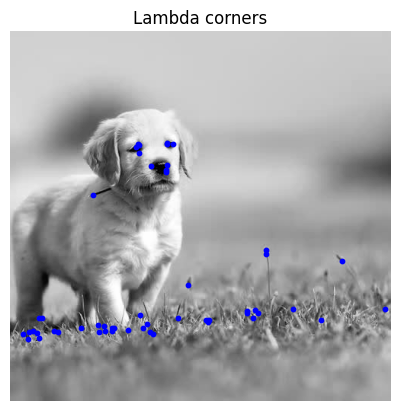

In [19]:
coords = np.argwhere(lambda_corners)
plt.imshow(image, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], c='b', s=10)
plt.title('Lambda corners')
plt.axis('off')
plt.show()